In [1]:
from __future__ import annotations

import importlib
import pathlib

import plotly.express as px
import polars
import theme

importlib.reload(theme)

<module 'theme' from '/home/jgpaul/workspace/sc24-proxystore-analysis/notebooks/theme.py'>

In [2]:
def load_data(filepath) -> polars.DataFrame:
    return polars.read_csv(filepath)

In [3]:
STAGES = {
    'processing_chrom_parts': 'Stage 1',
    'processing_2': 'Stage 2',
    'sifting': 'Stage 3',
    'mutation_overlap': 'Stage 4',
    'frequency': 'Stage 5',
}

RUNS = {
    'gc-trial': 'Baseline',
    'proxy-bench-trial': 'ProxyFutures',
}


def merge_stages(data: polars.DataFrame) -> polars.DataFrame:
    out = []
    for run in RUNS:
        run_data = data.filter(polars.col('name') == run)
        run_start = run_data['start'].min()
        for stage in STAGES:
            stage_data = run_data.filter(polars.col('task') == stage)
            start = stage_data['start'].min() - run_start
            end = stage_data['end'].max() - run_start
            out.append(
                {
                    'run': RUNS[run],
                    'stage': STAGES[stage],
                    'start': start,
                    'end': end,
                },
            )

    return polars.DataFrame(out)

In [76]:
def make_gantt(data, layout=None):
    data = data.with_columns(
        polars.from_epoch('start', time_unit='s'),
        polars.from_epoch('end', time_unit='s'),
    )

    colors = [0, 4, 1, 2, 3]
    fig = px.timeline(
        data,
        x_start='start',
        x_end='end',
        y='run',
        range_x=[data['start'].min(), data['end'].max()],
        color='stage',
        color_discrete_sequence=[
            px.colors.qualitative.Bold[i] for i in colors
        ],
        category_orders={'run': list(RUNS.values())},
        text=[f'Stage {(i%5)+1}' for i in range(len(data))],
    )
    fig.update_traces(
        # width=0.16,
        textposition='auto',
        insidetextanchor='start',
        insidetextfont=dict(size=9, color='white'),
        outsidetextfont=dict(size=9, color='black'),
    )

    layout = {} if layout is None else layout
    fig.update_layout(
        showlegend=False,
        legend=dict(
            title=None,
            yanchor='bottom',
            y=0.01,
            xanchor='right',
            x=0.995,
            tracegroupgap=1,
        ),
        barmode='group',
        bargap=0.05,
        bargroupgap=0,
        xaxis=dict(title='Runtime (s)', tickformat='%M:%S'),
        # yaxis=dict(tickangle=-90),
        # xaxis_type='linear',
        xaxis_title='Runtime (mm:ss)',
        yaxis_title=None,
        template='proxystore',
        **layout,
    )

    return fig

## Chameleon (Small Test)

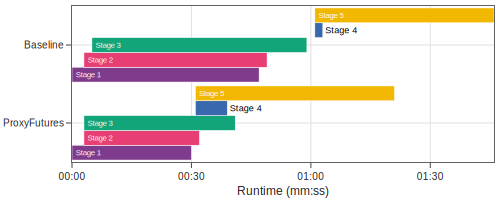

In [77]:
raw_data = load_data('../data/chameleon/3-1000genomes.csv')
data = merge_stages(raw_data)

layout = dict(width=500, height=200, margin=dict(l=5, r=5, t=5, b=5))
fig = make_gantt(data, layout=layout)
fig.show(renderer='svg')

figure_dir = pathlib.Path('../figures/chameleon/')
figure_dir.mkdir(exist_ok=True)
fig.write_image(figure_dir / '3-1000-genomes.pdf')